# ACCEL IMPLEMENTATION

In [ ]:
import os
import re
import time
import torch
import wandb
import imageio
import random
import copy
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from dataclasses import dataclass, asdict

from PIL import Image
from collections import deque
from gymnasium.spaces import Box

from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Wall
from minigrid.minigrid_env import MiniGridEnv, Grid
from minigrid.wrappers import ImgObsWrapper

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

from IPython.display import Image

device = 'cpu'
print(f"Using device: {device}")

# ====================================================
# Custom MiniGrid Environment 
# ====================================================
class MyCustomGrid(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, solvable_only=False, **kwargs):
        if config is None:
            config = {}
        self.config = config
        self.solvable_only = solvable_only

        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.config.get("seed_val"))

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=self.config['width'],
            max_steps=self.config['width'] * self.config['height'] * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )
 
    def _gen_grid(self, width, height):
        """
        Generate a new environment layout ensuring solvability if required.
        """
        
        check_stuck = 0
        while True:  # Keep regenerating until a solvable layout is found
            self.grid = Grid(width, height)
            self.grid.wall_rect(0, 0, width, height)

            # Place the goal
            goal_pos = self.config.get("goal_pos")
            if goal_pos is None:
                while True:
                    goal_r = self.rng.integers(1, height - 1)
                    goal_c = self.rng.integers(1, width - 1)
                    if self.grid.get(goal_c, goal_r) is None:
                        self.put_obj(Goal(), goal_c, goal_r)
                        self.config["goal_pos"] = (goal_c, goal_r)
                        break
            else:
                self.put_obj(Goal(), goal_pos[0], goal_pos[1])

            # Place the agent
            start_pos = self.config.get("start_pos")
            if start_pos is None:
                while True:
                    start_r = self.rng.integers(1, height - 1)
                    start_c = self.rng.integers(1, width - 1)
                    if self.grid.get(start_c, start_r) is None and (start_c, start_r) != self.config["goal_pos"]:
                        self.agent_pos = (start_c, start_r)
                        self.agent_dir = self.rng.integers(0, 4)
                        self.config["start_pos"] = (start_c, start_r)
                        break
            else:
                self.agent_pos = start_pos
                self.agent_dir = self.rng.integers(0, 4)
                self.config["start_pos"] = start_pos
            
            placed_blocks = 0
            
            # Maximum number of tries to place the blocks
            max_num_tries = 300
            
            # Place random walls using config parameters
            while placed_blocks < self.config["num_blocks"]:
                max_num_tries -= 1
                r = self.rng.integers(1, height - 1)
                c = self.rng.integers(1, width - 1)
                if max_num_tries <= 0:
                    print("Could not place all blocks in the grid.")
                    break
                if self.grid.get(c, r) is None and (c, r) != self.config["start_pos"] and (c, r) != self.config["goal_pos"]:
                    self.put_obj(Wall(), c, r)
                    placed_blocks += 1

            # Check solvability if required
            if not self.solvable_only or self._is_solvable():
                break
            
            check_stuck += 1
            if check_stuck > 50:
                #print("Re-randomizing start and goal positions...")
                self.config.pop("start_pos", None)
                self.config.pop("goal_pos", None)
                self.rng = np.random.default_rng(seed=self.config.get("seed_val") + check_stuck)
 
    def _is_solvable(self):
        """
        Uses Breadth-First Search (BFS) to check if there's a path 
        from the agent's start position to the goal.
        """
        start_pos = self.config["start_pos"]
        goal_pos = self.config["goal_pos"]
        if not start_pos or not goal_pos:
            return False

        queue = deque([start_pos])
        visited = set()
        visited.add(start_pos)

        while queue:
            x, y = queue.popleft()
            if (x, y) == goal_pos:
                return True

            # Possible moves: up, down, left, right
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                cell_obj = self.grid.get(nx, ny)
                if (
                    1 <= nx < self.width - 1 and  # Stay within grid bounds
                    1 <= ny < self.height - 1 and
                    (nx, ny) not in visited and
                    self.grid.get(nx, ny) is None or isinstance(cell_obj, Goal)
                ):
                    queue.append((nx, ny))
                    visited.add((nx, ny))
        return False  # No path found

    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))
    
    def update_config(self, new_config):
        """
        Update the environment configuration with a new config dict.
        """
        self.config = new_config
        self.reset()

def random_config(grid_size, num_blocks=None, seed=None):
    """
    Utility function to generate a random configuration dict.
    """
    
    max_blocks = int(((grid_size - 1) * (grid_size - 1)) / 2)
    
    if num_blocks is None:
        num_blocks = np.random.randint(1, max_blocks)
    else:
        num_blocks = min(num_blocks, max_blocks)
        
    config = {
        "width": grid_size,
        "height": grid_size,
        "num_blocks": num_blocks,
        "start_pos": None,
        "goal_pos": None,
        "edited": False,
        "seed_val": seed if seed is not None else np.random.randint(0, 1000)
    }
    
    # Set the start and goal positions
    env = MyCustomGrid(config)
    
    # Reset the environment to get the start and goal positions
    env.reset()
    
    # Get the new config from the environment
    config = env.config
        
    return config

def print_level_from_config(config, solvable_only=False):
    """
    Function to display a level configuration as an image.
    """
    
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=solvable_only)
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    #plt.title("Level Configuration: " + str(config))
    plt.axis("off")
    #plt.show()
    plt.close()
    
    return full_level_image
    
def edit_config(old_config):
    """
    Make a little edit to an existing configuration.
    """
    
    # Modify an existing configuration, adding randomness.
    max_blocks = int(((old_config["width"] - 1) * (old_config["height"] - 1)) / 2)
    
    new_config = dict(old_config)
    
    # Randomly change the number of blocks
    new_number_blocks = old_config["num_blocks"] + 1
    
    # Ensure the number of blocks is within bounds
    new_config["num_blocks"] = max(1, min(new_number_blocks, max_blocks))    
    
    # Mark the config as edited
    new_config["edited"] = True
    
    return new_config

def create_vectorized_env(config, n_envs=4, solvable_only=False):
    """
    Create a vectorized environment with n parallel environments.
    """
    return make_vec_env(lambda: MyCustomGrid(config, solvable_only), n_envs=n_envs, vec_env_cls=SubprocVecEnv)

# ====================================================
# Level Buffer
# ====================================================
class LevelBuffer: 
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []  # will store (config_dict, score)

    def add(self, config, score):
        self.data.append((config, score))
        if len(self.data) > self.max_size:
            self.data.sort(key=lambda x: x[1], reverse=True)
            self.data = self.data[: self.max_size]
            #it memorize only the highest score for each level

    def sample_config(self): 
        # Samples a level from the buffer, weighting the probabilities 
        # based on the scores.
        if len(self.data) == 0:
            return None
        scores = [item[1] for item in self.data]
        total = sum(scores)
        if total <= 1e-9:
            # fallback to uniform
            idx = np.random.randint(len(self.data))
            return self.data[idx][0]
        probs = [s / total for s in scores]
        idx = np.random.choice(len(self.data), p=probs)
        return self.data[idx][0]

# ====================================================
# Test Functions
# ====================================================
def test_model(model, config, gif_path="level.gif"):
    """Evaluate a model on a given environment instance."""
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=True)
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    frames = []  # List to store frames

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        frame = env.render()  # Capture frame as an image
        frames.append(Image.fromarray(frame))  # Convert to PIL image and store
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

    
    # Add to the gif also the last frame
    frame = env.render()
    frames.append(Image.fromarray(frame))
    
    # if the model has reached the goal, print the level
    if terminated:
        print("level finished from model")

    # Save frames as a GIF
    if frames:
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0
        )
    return total_reward  # Do not close env here, as we reuse it

# ====================================================
# Regret Calculation with Parallel Environments
# ====================================================
def calculate_regret_gae_vectorized(vec_env, model, max_steps, gamma, lam, 
                                    specific_env_indices=None):
    """
    Compute regrets in parallel using a vectorized environment.
    """
    n_envs = vec_env.num_envs

    # Decide which indices to track
    if specific_env_indices is None:
        tracked_indices = list(range(n_envs))
    else:
        tracked_indices = list(specific_env_indices)

    # We will store data only for "tracked_indices"
    all_rewards = {i: [] for i in tracked_indices}
    all_values = {i: [] for i in tracked_indices}
    all_dones =  {i: [] for i in tracked_indices}

    # Initialize the environment
    obs_array = vec_env.reset()
    obs_tensor = torch.as_tensor(obs_array, dtype=torch.float32, device=device)

    # For stepping the entire vec_env in parallel, track if each env is done
    done_flags = [False] * n_envs

    for step in range(max_steps):
        # If all tracked envs are done, stop collecting
        if all(done_flags[i] for i in tracked_indices):
            break

        with torch.no_grad():
            # The model predict handles all sub-envs
            actions, _ = model.predict(obs_array, deterministic=True)
            # We also get predicted values (shape: (n_envs,))
            values_t = model.policy.predict_values(obs_tensor).squeeze(dim=-1)

        # Step all n_envs in parallel
        new_obs_array, rewards, dones, infos = vec_env.step(actions)

        # Store reward/value/done for tracked envs that are still alive
        for i in tracked_indices:
            if not done_flags[i]:
                all_rewards[i].append(rewards[i])
                all_values[i].append(values_t[i].item())
                all_dones[i].append(dones[i])

        # Update the done flags for all envs
        done_flags = [done_flags[i] or dones[i] for i in range(n_envs)]

        # Update obs
        obs_array = new_obs_array
        obs_tensor = torch.as_tensor(obs_array, dtype=torch.float32, device=device)

    # Compute terminal values for each env (if not done, we take V(s_final))
    with torch.no_grad():
        terminal_values = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()

    # Now compute the regret formula for each tracked env
    regrets_dict = {}
    for i in tracked_indices:
        rewards_i = all_rewards[i]
        values_i = all_values[i]
        dones_i   = all_dones[i]

        # If no trajectory was collected, regret = 0
        if len(rewards_i) == 0:
            regrets_dict[i] = 0.0
            continue

        # If the last step wasn't done, append the final predicted value
        if not dones_i[-1]:
            values_i.append(float(terminal_values[i]))
        else:
            values_i.append(0.0)

        # Construct the delta array:
        # delta_t = r_t + gamma * (1 - done_t) * V_{t+1} - V_t
        deltas = []
        for t in range(len(rewards_i)):
            delta_t = (rewards_i[t]
                       + gamma * values_i[t + 1] * (1 - dones_i[t])
                       - values_i[t])
            deltas.append(delta_t)

        # We now implement exactly:
        #   (1/T) * sum_{t=0..T-1} max( sum_{k=t..T-1} (gamma*lambda)^(k-t) * delta_k, 0 )
        # Let N = len(deltas). If the trajectory ended early, T=N.

        N = len(deltas)
        partial_sums = [0.0]*N

        # We can compute sum_{k=t}^{N-1} (gamma*lam)^(k-t) * delta_k
        # efficiently with a backward recursion:
        #     P_N = 0
        #     P_t = delta_t + (gamma*lam)*P_{t+1}
        # Then partial_sums[t] = P_t
        # Then we take max(P_t, 0), sum up, then divide by N.

        P_next = 0.0
        for t in reversed(range(N)):
            P_t = deltas[t] + (gamma * lam) * P_next
            partial_sums[t] = max(P_t, 0.0)
            P_next = P_t  # store for next iteration

        env_regret = sum(partial_sums) / N
        regrets_dict[i] = env_regret

    return [regrets_dict[i] for i in tracked_indices]

# ==================================================== 
# DR-PLR-ACCEL Main Function
# ====================================================
def main_accel_parallel(total_iterations, replay_prob, train_steps, level_buffer_size,
               initial_fill_size, grid_size, n_envs, edit_levels, regret_threshold,
               easy_start, domain_randomization, name, test_every_n_iterations, test_on_levels,
               lr, batch_size):
    """
    Main ACCEL function with parallel environments.
    Re-ordered to match ACCEL pseudocode:
      - d=0: sample new level, collect trajectory (stop-grad), compute regret, update buffer
      - d=1: sample from buffer, collect trajectory & update policy, edit, collect trajectory (stop-grad),
             compute regrets, update buffer
    """
    # Initialize W&B
    # wandb.init(project="accel", config=config, mode="disabled")
    
    def plot_display_avg_rew_list(avg_list):
        plt.plot(avg_list)
        plt.xlabel("Iteration")
        plt.ylabel("Average Reward")
        plt.title("Average Reward Progress during Training")
        plt.grid(True)
        plt.savefig(f"plots/avg_reward_progress_{name}_{grid_size}x{grid_size}.png")
        plt.show()
    
    # Create a level buffer
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    
    # Generate a random configuration as a placeholder
    dummy_config = random_config(grid_size)
    
    # Create a vectorized environment
    vectorized_env = create_vectorized_env(dummy_config, n_envs=n_envs)

    # Initialize PPO
    print("Initializing student model PPO...")
    student_model = PPO(
        "MlpPolicy",
        vectorized_env,
        verbose=0,
        n_steps=512,
        batch_size=batch_size,
        learning_rate=lr,
        device=device
    )

    avg_rewards_list = []
            
    # ====================================================
    # Initial buffer fill
    # ====================================================
    if not domain_randomization:
        print(f"Populating buffer with {initial_fill_size} initial levels (regret > {regret_threshold})...")
        
        while len(level_buffer.data) < initial_fill_size:
            # Generate n_envs configs
            configs = []
            for _ in range(n_envs):
                if easy_start:
                    cfg = random_config(grid_size, num_blocks=2, seed=42+len(level_buffer.data))
                else:
                    cfg = random_config(grid_size, seed=42+len(level_buffer.data))
                configs.append(cfg)

            # Set every environment with a different config
            for i in range(n_envs):
                vectorized_env.env_method("update_config", configs[i], indices=i)
                
            # Train the model using the vectorized environment
            student_model.learn(total_timesteps=train_steps)
            
            # Calculate regret for each environment
            regrets = calculate_regret_gae_vectorized(
                vectorized_env, student_model, max_steps=1000, gamma=0.99, lam=0.95
            )
            
            # Add the configs with regret > threshold to the buffer
            for i in range(n_envs):
                cfg = configs[i]
                regret = regrets[i]
                if regret < regret_threshold:
                    continue
                level_buffer.add(cfg, regret)

    ## ====================================================
    ##  Main ACCEL loop
    ## ====================================================
    
    iteration_regrets = []
    iteration, skipped = 0, 0
    
    print("\nMain training loop...")
    
    # ====================================================
    # Domain Randomization
    # ====================================================

    # If domain randomization is activated, we just do random levels.
    if domain_randomization:
        while iteration < total_iterations:
            # Optional test code block:
            """
            if iteration % test_every_n_iterations == 0:
                rewards = 0
                for i in range(test_on_levels):
                    test_config = random_config(grid_size=grid_size, seed=12945 + i)
                    reward = test_model(student_model, test_config)
                    rewards += reward
                print(f"Reward over {test_on_levels} levels: {rewards}")
                avg_rewards_list.append(rewards)
            """

            print(f"\n=== ITERATION {iteration + 1}/{total_iterations} (Domain Randomization) ===")
            
            # Create n_envs random configs
            configs = []
            for _ in range(n_envs):
                cfg = random_config(grid_size, seed=42+iteration)
                configs.append(cfg)
            
            # Set every environment with a different config
            for i in range(n_envs):
                vectorized_env.env_method("update_config", configs[i], indices=i)

            # Train the model using the vectorized environment
            student_model.learn(total_timesteps=train_steps)
            iteration += n_envs  # counting it that way to keep your style

        student_model.save(f"models/{name}")
        print(f"Model saved as models/{name}")

   
        return student_model

    # ----------------------------------------------------
    # Otherwise: actual ACCEL logic (no domain randomization)
    # ----------------------------------------------------
    while iteration < total_iterations + skipped:
        print(f"\n=== ITERATION {iteration + 1}/{total_iterations + skipped} SKIPPED: {skipped}, skip ratio: {skipped / (iteration + 1):.2f} ===")

        # Optional test code block:
        """
        if iteration % test_every_n_iterations == 0:
            rewards = 0
            for i in range(test_on_levels):
                test_config = random_config(grid_size=grid_size, seed=12945 + i)
                reward = test_model(student_model, test_config)
                rewards += reward
            print(f"Reward over {test_on_levels} levels: {rewards}")
            avg_rewards_list.append(rewards)
        """

        # Decide for each environment: replay or new level
        # d[i] = True means "replay" (d=1), else new level (d=0)
        use_replay = [np.random.rand() < replay_prob for _ in range(n_envs)]
        
        # ----------------------------------------------------
        # Step A: d=0. Sample new levels, collect trajectory (NO policy update), compute regrets, update buffer
        # ----------------------------------------------------
        new_indices = [i for i, rep in enumerate(use_replay) 
                       if (not rep) or (len(level_buffer.data) == 0)]
        # We will gather these new-level environments, set them, 
        # collect regrets with no policy update, then update the buffer.
        if len(new_indices) > 0:
            new_configs = []
            for i in new_indices:
                # Sample new level from generator
                cfg = random_config(grid_size, seed=42+iteration+i) 
                new_configs.append(cfg)

            # Update only those sub-environments with the new configs
            for idx, env_i in enumerate(new_indices):
                vectorized_env.env_method("update_config", new_configs[idx], indices=env_i)
            
            # --- Collect policy trajectory with stop-gradient ---
            # We do NOT call student_model.learn(...) here,
            # just compute regrets directly. 
            regrets_new = calculate_regret_gae_vectorized(
                vectorized_env, student_model, max_steps=1024, gamma=0.99, lam=0.95, 
                specific_env_indices=new_indices
            )

            # Update buffer for those that pass threshold
            for idx, env_i in enumerate(new_indices):
                r = regrets_new[idx]
                if r > regret_threshold:
                    level_buffer.add(new_configs[idx], r)
                    iteration_regrets.append(r)
                else:
                    skipped += 1

            # Increase iteration count by however many new envs we processed
            iteration += len(new_indices)
        
        # ----------------------------------------------------
        # Step B: d=1. Replay levels from buffer, 
        #         1) collect trajectory & update policy
        #         2) edit level
        #         3) collect new trajectory (stop-grad)
        #         4) compute regrets, update buffer
        # ----------------------------------------------------
        replay_indices = [i for i, rep in enumerate(use_replay) 
                          if rep and (len(level_buffer.data) > 0)]
        if len(replay_indices) > 0:
            # 1) Sample from buffer and set those envs
            replay_original_cfgs = []
            for i in replay_indices:
                cfg = level_buffer.sample_config()
                replay_original_cfgs.append(cfg)

            for idx, env_i in enumerate(replay_indices):
                vectorized_env.env_method("update_config", replay_original_cfgs[idx], indices=env_i)
            
            # 2) Collect policy trajectory **AND update policy** here
            student_model.learn(total_timesteps=train_steps)

            # 3) Edit level
            # If edit_levels is True, we edit the replayed level
            replay_edited_cfgs = []
            for idx, env_i in enumerate(replay_indices):
                original = replay_original_cfgs[idx]
                if edit_levels:
                    edited = edit_config(original)
                else:
                    edited = original  # no edit
                replay_edited_cfgs.append(edited)
                # Update that sub-environment with the edited config
                vectorized_env.env_method("update_config", edited, indices=env_i)
            
            # 4) Collect new trajectory (stop-grad) on the edited level
            regrets_replay_edited = calculate_regret_gae_vectorized(
                vectorized_env, student_model, max_steps=1024, gamma=0.99, lam=0.95,
                specific_env_indices=replay_indices
            )

            # Optionally, we also want the regret for the *original* level,
            # but we only saved that before calling .learn(...). 
            # We can compute it again if needed. Typically, we'd do it right before 
            # the policy update.
            for idx, env_i in enumerate(replay_indices):
                # Re-load original config
                vectorized_env.env_method("update_config", replay_original_cfgs[idx], indices=env_i)
            # Now compute regret with the *updated* policy (post-update).
            regrets_replay_original_after_update = calculate_regret_gae_vectorized(
                vectorized_env, student_model, max_steps=512, gamma=0.99, lam=0.95,
                specific_env_indices=replay_indices
            )
            
            # 5) Update buffer if regrets meet threshold
            for idx, env_i in enumerate(replay_indices):
                s_orig = regrets_replay_original_after_update[idx]
                s_edit = regrets_replay_edited[idx]
                
                # Add original if passes threshold
                if s_orig > regret_threshold:
                    level_buffer.add(replay_original_cfgs[idx], s_orig)
                    iteration_regrets.append(s_orig)
                else:
                    skipped += 1

                # Add edited if passes threshold
                if s_edit > regret_threshold:
                    level_buffer.add(replay_edited_cfgs[idx], s_edit)
                    iteration_regrets.append(s_edit)
                else:
                    skipped += 1

            # Increase iteration count by however many replay envs we processed
            iteration += len(replay_indices)
        
        # End of iteration loop

    # close the environment
    vectorized_env.close()
    
    # ====================================================
    # Plotting and Saving
    # ====================================================
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during Training")
    plt.grid(True)
    plt.savefig(f"plots/regret_progress_{name}_{grid_size}x{grid_size}.png")
    #plt.show()
    
    print("\nDone. Final buffer size:", len(level_buffer.data))
    print("Top-5 hardest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1], reverse=True)
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        
    print("Top-5 easiest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1])
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
    
    wandb.finish()
    
    # Save the model
    student_model.save(f"models/{name}")
    print(f"Model saved as models/{name}")

    return student_model

Using device: cpu


# TRAIN

Running dr_model_8x8 with config: {'name': 'dr_model_8x8', 'grid_size': 8, 'train_steps': 384, 'total_iterations': 64, 'test_every_n_iterations': 12, 'replay_prob': 0.8, 'level_buffer_size': 256, 'initial_fill_size': 128, 'regret_threshold': 0.0, 'n_envs': 6, 'test_on_levels': 100, 'edit_levels': False, 'easy_start': False, 'domain_randomization': True, 'lr': 0.001, 'batch_size': 128}
Initializing student model PPO...

Main training loop...

=== ITERATION 1/64 (Domain Randomization) ===

=== ITERATION 7/64 (Domain Randomization) ===

=== ITERATION 13/64 (Domain Randomization) ===

=== ITERATION 19/64 (Domain Randomization) ===

=== ITERATION 25/64 (Domain Randomization) ===

=== ITERATION 31/64 (Domain Randomization) ===

=== ITERATION 37/64 (Domain Randomization) ===

=== ITERATION 43/64 (Domain Randomization) ===

=== ITERATION 49/64 (Domain Randomization) ===

=== ITERATION 55/64 (Domain Randomization) ===

=== ITERATION 61/64 (Domain Randomization) ===
Model saved as models/dr_mode

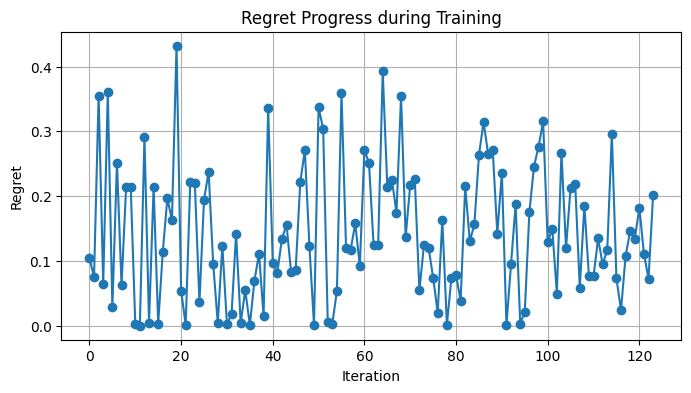

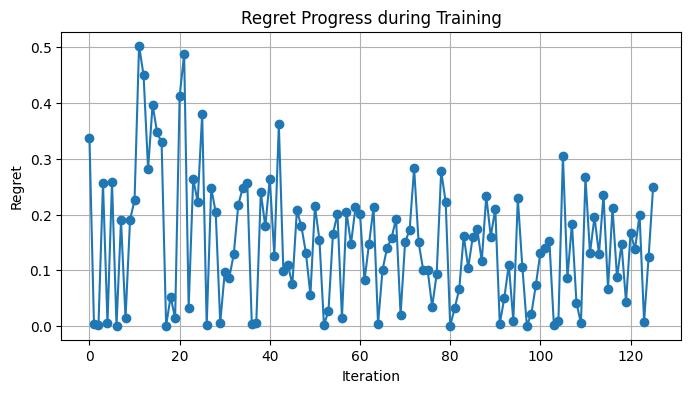

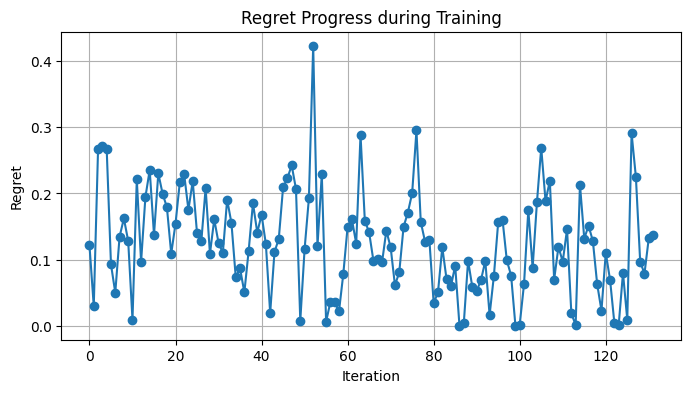

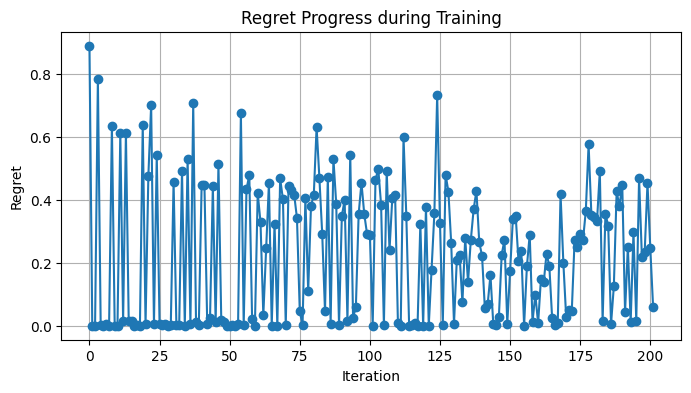

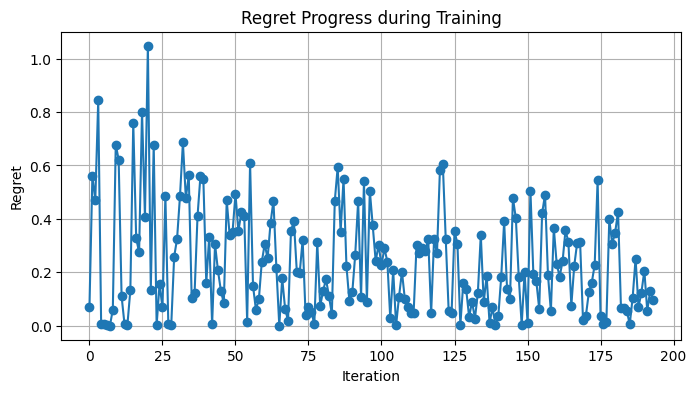

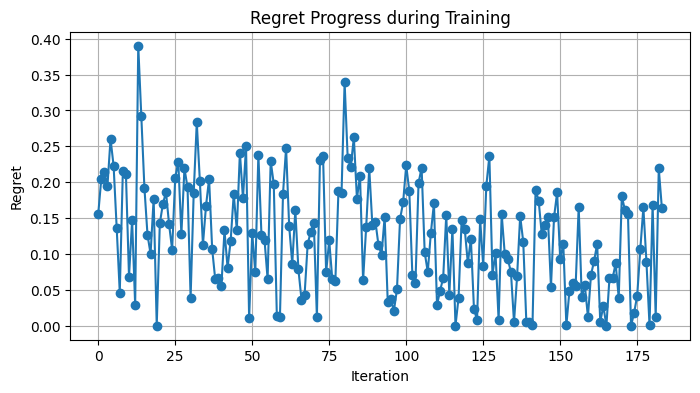

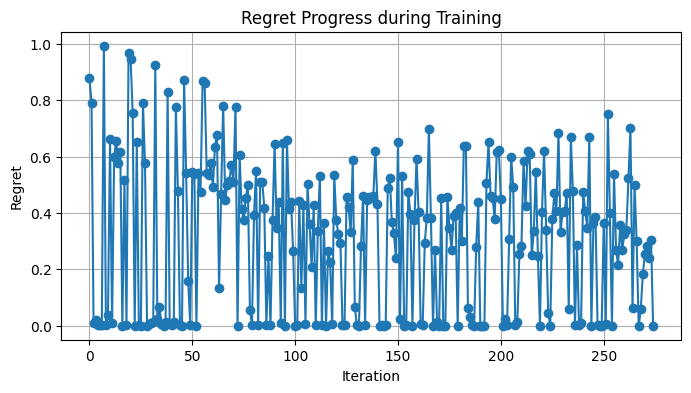

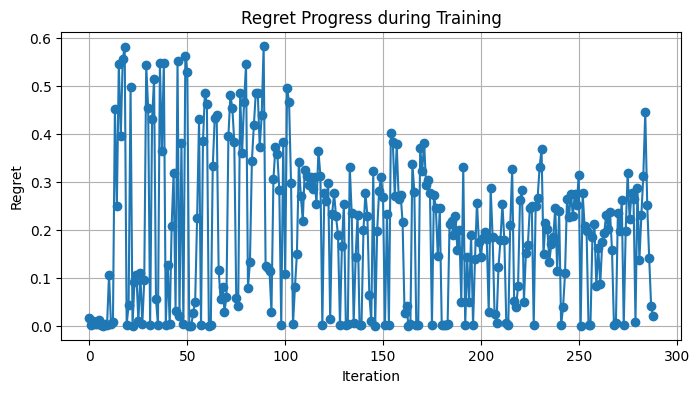

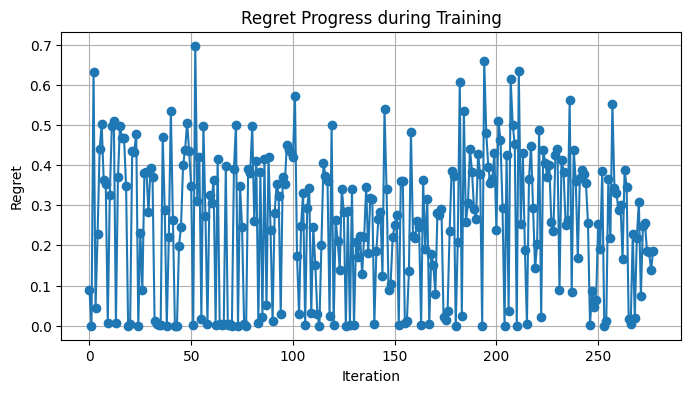

In [5]:
import json

@dataclass
class Config:
    name: str = "model"
    grid_size: int = 6  # Grid size
    
    # Dynamic parameters (set in __post_init__)
    train_steps: int = None
    total_iterations: int = None
    test_every_n_iterations: int = None

    replay_prob: float = 0.8                    # probability of replaying a level (default: 80%)
    level_buffer_size: int = 256                # max size of level buffer (default: 256)
    initial_fill_size: int = 128                # initial fill size of level buffer, has to have regret > regret_threshold (default: 128)
    regret_threshold: float = 0.00              # regret threshold for adding levels to buffer (default: 0.00)
    n_envs: int = 6                             # number of parallel environments (default: 6)
    edit_levels: bool = True                    # flag for editing levels (ACCEL) (default: True)
    easy_start: bool = True                     # flag for easy start (ACCEL-ES) (default: True)
    domain_randomization: bool = False          # flag for domain randomization (default: False)
    lr: float = 1e-3                            # learning rate of PPO (default: 1e-3)
    batch_size: int = 128                       # batch size of PPO (default: 128)
    test_on_levels: int = 100                   # number of levels to test on, slows down training (default: 100) NOT USED


    def update_dependent_params(self):
        """Recalculate dynamic parameters after updating grid_size."""
        self.train_steps = self.grid_size * self.grid_size * self.n_envs        # grid_size^2 * n_envs (for each level)
        self.total_iterations = self.grid_size**2                               # grid_size^2 iterations (total number of levels)
        self.test_every_n_iterations = self.n_envs * 2                          # test every n_envs * 2 iterations (slows down training) NOT USED



if __name__ == "__main__":
    base_config = Config()  # elements are set to default values and dynamically calculated

    # Define different configuration
    configs = [
        {"name": f"dr_model_6x6", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 6},
        {"name": f"plr_model_6x6", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 6},
        {"name": f"accel_model_6x6", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 6},
        {"name": f"accel_model_easy_6x6", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 6},
        {"name": f"dr_model_8x8", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 8},
        {"name": f"plr_model_8x8", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 8},
        {"name": f"accel_model_8x8", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 8},
        {"name": f"accel_model_easy_8x8", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 8},
        {"name": f"dr_model_10x10", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 10},
        {"name": f"plr_model_10x10", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 10},
        {"name": f"accel_model_10x10", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 10},
        {"name": f"accel_model_easy_10x10", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 10},
        {"name": f"dr_model_12x12", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 12},
        {"name": f"plr_model_12x12", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 12},
        {"name": f"accel_model_12x12", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 12},
        {"name": f"accel_model_easy_12x12", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 12},     
    ]

    # Run models with different configurations
    for config_updates in configs:
        config = copy.deepcopy(base_config)  # Ensure each config is independent
        
        # Update attributes and recalculate dependent parameters
        for key, value in config_updates.items():
            setattr(config, key, value)
        config.update_dependent_params()  # Ensure recalculated values reflect changes

        # Save the dataclass as a dictionary
        with open(f"models/{config.name}.json", "w") as f:
            json.dump(asdict(config), f)
        
        print(f"Running {config.name} with config: {asdict(config)}")    
        main_accel_parallel(**asdict(config))
        print("\n\n============================================\n\n")


# Evaluation

In [43]:
model_dict = {
    "DR 6x6": "dr_model_6x6.zip",
    "PLR 6x6": "plr_model_6x6.zip",
    "ACCEL 6x6": "accel_model_6x6.zip",
    "ACCEL-EasyStart 6x6": "accel_model_easy_6x6.zip",
    
    "DR 8x8": "dr_model_8x8.zip",
    "PLR 8x8": "plr_model_8x8.zip",
    "ACCEL 8x8": "accel_model_8x8.zip",
    "ACCEL-EasyStart 8x8": "accel_model_easy_8x8.zip",
    
    "DR 10x10": "dr_model_10x10.zip",
    "PLR 10x10": "plr_model_10x10.zip",
    "ACCEL 10x10": "accel_model_10x10.zip",
    "ACCEL-EasyStart 10x10": "accel_model_easy_10x10.zip",
    
    "DR 12x12": "dr_model_12x12.zip",
    "PLR 12x12": "plr_model_12x12.zip",
    "ACCEL 12x12": "accel_model_12x12.zip",
    "ACCEL-EasyStart 12x12": "accel_model_easy_12x12.zip",
}

num_envs = 6  # Adjust based on CPU cores
current_grid_size = None
vec_env = None


# Function to create an environment instance
def make_env(grid_size):
    def _init():
        dummy_config = random_config(grid_size, seed=42)  # Random config for initialization
        env = MyCustomGrid(dummy_config, solvable_only=True)  # Initialize with config
        return env
    return _init

for i, (name, file) in enumerate(model_dict.items()):
    model = PPO.load(f"models/{file}")

    # Extract grid size from file name
    grid_size = int(re.search(r"(\d+)x(\d+)", file).group(1))

    # Create new environments only when the grid size changes
    if grid_size != current_grid_size:
        if vec_env is not None:
            vec_env.close()  # Close existing environments
    
        env_fns = [make_env(grid_size) for _ in range(num_envs)]
        vec_env = SubprocVecEnv(env_fns)
        current_grid_size = grid_size

    # Generate 100 unique configurations
    configs = [random_config(grid_size, seed=j) for j in range(100)]

    # Evaluate over 100 levels
    all_rewards = []
    for j in range(0, 100, num_envs):
        
        # Update the environments with the new configurations
        for k in range(num_envs):
            if j + k < 100:
                vec_env.env_method("update_config", configs[j+k], indices=k)

        # Run a single episode per configuration
        mean_reward, _ = evaluate_policy(model, vec_env, n_eval_episodes=10, warn=False, deterministic=True)
        
        all_rewards.append(mean_reward)

    # Compute total mean reward over 100 levels
    final_mean_reward = sum(all_rewards) / len(all_rewards)
    print(f"{name}: Total reward over {100} levels: {final_mean_reward * 100:.2f}")


    if i % 4 == 3:
        print("\n")

if vec_env is not None:
    vec_env.close()  # Cleanup resources after all tests


DR 6x6: Total reward over 100 levels: 57.75
PLR 6x6: Total reward over 100 levels: 85.13
ACCEL 6x6: Total reward over 100 levels: 80.14
ACCEL-EasyStart 6x6: Total reward over 100 levels: 90.17


DR 8x8: Total reward over 100 levels: 28.35
PLR 8x8: Total reward over 100 levels: 62.61
ACCEL 8x8: Total reward over 100 levels: 77.87
ACCEL-EasyStart 8x8: Total reward over 100 levels: 76.50


DR 10x10: Total reward over 100 levels: 13.52
PLR 10x10: Total reward over 100 levels: 49.23
ACCEL 10x10: Total reward over 100 levels: 46.48
ACCEL-EasyStart 10x10: Total reward over 100 levels: 54.30


DR 12x12: Total reward over 100 levels: 1.76
PLR 12x12: Total reward over 100 levels: 28.40
ACCEL 12x12: Total reward over 100 levels: 38.08
ACCEL-EasyStart 12x12: Total reward over 100 levels: 36.08




### Results from old evaluation 

#### lr=1e-4, iterarions=grid size^3


6x6  
Total reward over 100 levels for DR: 3.94  
Total reward over 100 levels for PLR: 40.41  
Total reward over 100 levels for ACCEL: 69.65  
Total reward over 100 levels for ACCEL-EasyStart: 71.70  


8x8  
Total reward over 100 levels for DR: 5.92  
Total reward over 100 levels for PLR: 23.92  
Total reward over 100 levels for ACCEL: 36.76  
Total reward over 100 levels for ACCEL-EasyStart: 44.45  

10x10  
Total reward over 100 levels for DR: 2.97  
Total reward over 100 levels for PLR: 13.76  
Total reward over 100 levels for ACCEL: 12.79  
Total reward over 100 levels for ACCEL-EasyStart: 31.01  

12x12  
Total reward over 100 levels for DR: 27.15  
Total reward over 100 levels for PLR: 23.96  
Total reward over 100 levels for ACCEL: 12.80  
Total reward over 100 levels for ACCEL-EasyStart: 26.82  


#### lr=1e-3, iterarions=grid size^2


6x6  
DR 6x6: Total reward over 100 levels: 57.75  
PLR 6x6: Total reward over 100 levels: 85.13  
ACCEL 6x6: Total reward over 100 levels: 80.14  
ACCEL-EasyStart 6x6: Total reward over 100 levels: 90.17  

8x8  
DR 8x8: Total reward over 100 levels: 28.35  
PLR 8x8: Total reward over 100 levels: 62.61  
ACCEL 8x8: Total reward over 100 levels: 77.87  
ACCEL-EasyStart 8x8: Total reward over 100 levels: 76.50  

10x10  
DR 10x10: Total reward over 100 levels: 13.52  
PLR 10x10: Total reward over 100 levels: 49.23  
ACCEL 10x10: Total reward over 100 levels: 46.48  
ACCEL-EasyStart 10x10: Total reward over 100 levels: 54.30  

12x12  
DR 12x12: Total reward over 100 levels: 1.76  
PLR 12x12: Total reward over 100 levels: 28.40  
ACCEL 12x12: Total reward over 100 levels: 38.08  
ACCEL-EasyStart 12x12: Total reward over 100 levels: 36.08  

# Visualization

In [39]:
def gif_level_generation(seed=42):
    config = random_config(14, seed=seed, num_blocks=1)

    level_frames = []
    for i in range(50):
        # Print the level
        level_image = print_level_from_config(config)
        
        # Edit the config
        config = edit_config(config)
        
        # Save the level image
        level_frames.append(level_image)

    # Create a GIF using the frames and the library imageio
    imageio.mimsave("level.gif", level_frames, fps=15)

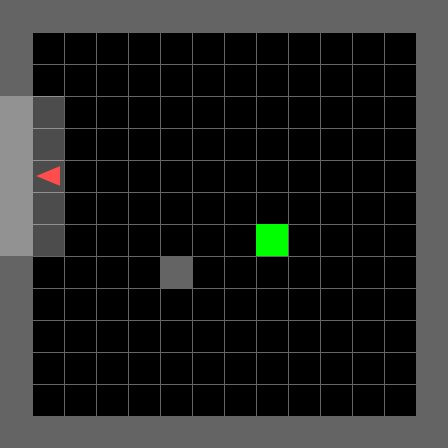

In [159]:
gif_level_generation(43)
Image("level.gif")

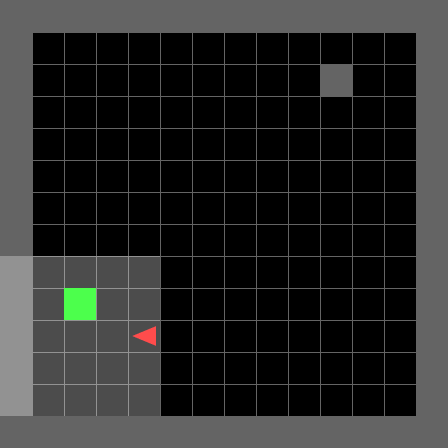

In [38]:
gif_level_generation(44)
Image("level.gif")

In [79]:
from PIL import Image

def test_model(model, config, gif_path="level.gif"):
    """Evaluate a model on a given environment instance."""
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=True)
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    frames = []  # List to store frames

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        frame = env.render()  # Capture frame as an image
        frames.append(Image.fromarray(frame))  # Convert to PIL image and store
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

    
    # Add to the gif also the last frame
    frame = env.render()
    frames.append(Image.fromarray(frame))
    
    # if the model has reached the goal, print the level
    if terminated:
        print("level finished from model")

    # Save frames as a GIF
    if frames:
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0
        )
    return total_reward  # Do not close env here, as we reuse it


model_dr = PPO.load("models/dr_model_6x6")
model_plr = PPO.load("models/plr_model_6x6")
model_accel = PPO.load("models/accel_model_6x6")
model_accel_easy = PPO.load("models/accel_model_easy_6x6")


# Test the model on a random level
config = random_config(8, seed=4)

print("Creating gifs for each model...")
test_model(model_dr, config, gif_path=f"gifs/level_dr.gif")
test_model(model_plr, config, gif_path=f"gifs/level_plr.gif")
test_model(model, config, gif_path=f"gifs/level_accel.gif")
test_model(model_accel_easy, config, gif_path=f"gifs/level_accel_easy.gif")
print()

Creating gifs for each model...
level finished from model



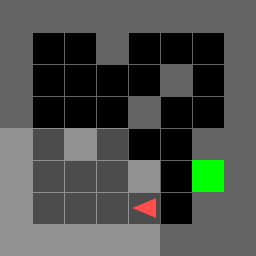

In [85]:
from IPython.display import Image

Image("gifs/level_dr.gif")

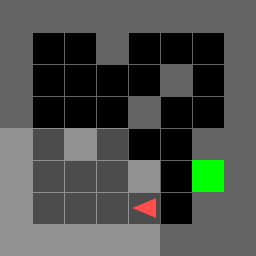

In [86]:
Image("gifs/level_plr.gif")

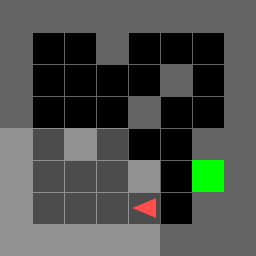

In [87]:
Image("gifs/level_accel.gif")

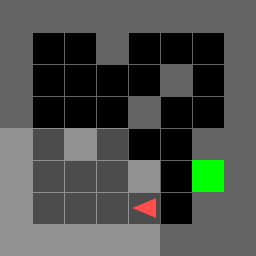

In [88]:
Image("gifs/level_accel_easy.gif")

Random configuration: {'width': 8, 'height': 8, 'num_blocks': 4, 'start_pos': (3, 4), 'goal_pos': (5, 1), 'edited': False, 'seed_val': 42}


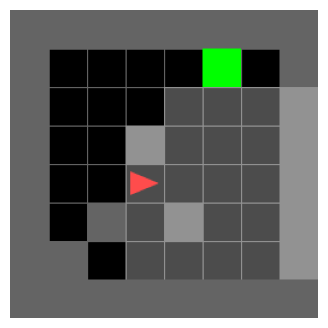

In [157]:
# generate random configurations
config = random_config(8, seed=42, num_blocks=4)
print("Random configuration:", config)


# Print the level
env = MyCustomGrid(config, render_mode='rgb_array')
env.reset()
full_level_image = env.render()  # This should return an RGB image of the full grid

plt.figure(figsize=(4, 4))
plt.imshow(full_level_image)
plt.axis("off")
plt.show()